In this notebook I will run bootstrap confidence intervals on my simulations:

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import array as arr
from scipy.stats import kde
from sklearn.utils import resample
%matplotlib inline

In [3]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True);

# Least-Squares calculators
In linear terms, the equation is very simple. I am simply solving a linear equation and find the slope:

\begin{equation}
Y = X \beta{} + \epsilon\\
s_{v} =  \sigma_{bs} * \rho + background noise
\end{equation}

where\
$s_{v}$ is volume backscatter coefficient ($m^{-1}$),\
$\sigma_{bs}$ is the backscattering cross-sectional ($m^2$) or the acoustic signature,\
$\rho$ is the density (individuals/$m^3$). This is the unknown I want to predict! 

## My problem
I am trying to find the "optimal" density of each functional group that will results in the measured volume backscatter coefficient. 
For each functional group (Copepod, Amphipod and Chaetognaths) I ran 1000 simulations to find the "spread" of backscattering cross-section. The model varies with length, orientation and acoustic properties of the functional group. 
I have tried to solve the equation with the mean of the 1000 simulations of each functional group but I think it is important - if possible- to consider all the possible iterations and the probability distribution of the ensemble of simulations.

## Read data for X

For each functional group I have 1000 possible backscattering cross-sections.

In [15]:
simulations = pd.read_feather('../ZooScatStuff/my_data.feather')
# Add a row for sigma_bs
simulations['sigbs'] = 10**(simulations.TS/10);
simulations

,TS,freq,L,la,g,h,orient,spec,sigbs
0,-115.169633,100.000,1.817697,2.667725,1.019749,1.024871,89.825195,Copepod,3.041142e-12
1,-115.068791,100.625,1.817697,2.667725,1.019749,1.024871,89.825195,Copepod,3.112583e-12
2,-114.968667,101.250,1.817697,2.667725,1.019749,1.024871,89.825195,Copepod,3.185175e-12
3,-114.869251,101.875,1.817697,2.667725,1.019749,1.024871,89.825195,Copepod,3.258929e-12
4,-114.770536,102.500,1.817697,2.667725,1.019749,1.024871,89.825195,Copepod,3.333853e-12
...,...,...,...,...,...,...,...,...,...
5606995,-82.180055,597.500,3.674454,7.690506,0.995495,1.110457,-8.223252,FishLarvae,6.053332e-09
5606996,-82.175165,598.125,3.674454,7.690506,0.995495,1.110457,-8.223252,FishLarvae,6.060151e-09
5606997,-82.170315,598.750,3.674454,7.690506,0.995495,1.110457,-8.223252,FishLarvae,6.066923e-09
5606998,-82.165505,599.375,3.674454,7.690506,0.995495,1.110457,-8.223252,FishLarvae,6.073646e-09


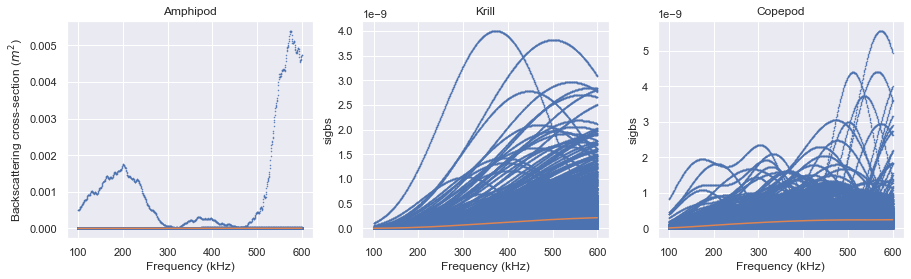

In [16]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(simulations.freq[simulations['spec']=='Amphipod'], simulations.sigbs[simulations['spec']=='Amphipod'], '.', markersize=1)
sns.lineplot(x=simulations.freq[simulations['spec']=='Amphipod'], y=simulations.sigbs[simulations['spec']=='Amphipod'])
plt.legend([],[], frameon=False)
plt.title('Amphipod')
plt.ylabel('Backscattering cross-section ($m^2$)')
plt.xlabel('Frequency (kHz)')

plt.subplot(132)
plt.plot(simulations.freq[simulations['spec']=='Krill'], simulations.sigbs[simulations['spec']=='Krill'], '.', markersize=1)
sns.lineplot(x=simulations.freq[simulations['spec']=='Krill'], y=simulations.sigbs[simulations['spec']=='Krill'])                                                                                                                              
plt.legend([],[], frameon=False)
plt.title('Krill')
plt.xlabel('Frequency (kHz)')

plt.subplot(133)
plt.plot(simulations.freq[simulations['spec']=='Copepod'], simulations.sigbs[simulations['spec']=='Copepod'], '.', markersize=1)
sns.lineplot(x=simulations.freq[simulations['spec']=='Copepod'], y=simulations.sigbs[simulations['spec']=='Copepod'])                                                                                                                              
plt.legend([],[], frameon=False)
plt.title('Copepod')
plt.xlabel('Frequency (kHz)');

The mean is shown as the orange line. Each dotted line presents a simulation.                                                                                                         

## Maybe mean is ok. X with weighted mean

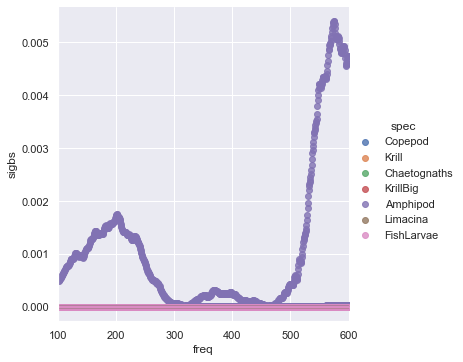

In [6]:
sns.lmplot(data=simulations, x="freq", y="sigbs", hue="spec");  

## Using the seaboard bootstraping method to get CI 95%
https://en.wikipedia.org/wiki/Bootstrapping_(statistics) \

Dragicevic, P. (2016). Fair statistical communication in HCI. In Modern Statistical Methods for HCI (pp. 291-330). Springer, Cham. :
[It] consists of generating many alternative datasets from the experimental data by randomly drawing observations with replacement. The variability across these datasets is assumed to approximate sampling error and is used to compute so-called bootstrap confidence intervals. [...] It is very versatile and works for many kinds of distributions.

This is due to the Central Limit Theorem: a large number of independent random samples will approach a normal distribution even if the underlying population is not normally distributed.

My distribution is not normal. This is an appropriate way. I have ALOT of iterations. 

In [7]:
def bootstrap_interval(simulations, spec, percentiles=(2.5, 97.5), n_boots=100):
    """Extract mean and bootstrap a confidence interval for the mean of columns data with freq and sigmabs.
    simulations: dataframe containing all the model runs from scattering models
    spec: string describing the functional group.
    Output is the mean and the bootstrap confidence intervals of the mean.
    """
    # First, calculate mean for each frequency of the whole sample
    mean = simulations[simulations.spec==spec].groupby(['freq']).mean()['sigbs']
    
    
    # Resample , calculate mean repeat n_boot times, then calculate the SPREAD of the MEANS.
    sigbs = simulations.sigbs[simulations.spec==spec]
    freq = simulations.freq[simulations.spec==spec]
    freqs = np.unique(freq)
    
    # Create our empty array to fill the results
    ci_boot = np.zeros([2, len(freqs)])

    # Resample over each frequency
    for i in range(len(freqs)):
        sigbs_selectfreq = sigbs[freq==freqs[i]]

        # Create our empty array to fill the results              
        bootstrap_means = np.zeros([n_boots])

        # Resample within the values of the selected frequency and calculate the mean
        for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
            random_sample = resample(sigbs_selectfreq)
            bootstrap_means[ii] = random_sample.mean(axis=0)

        # Save the percentiles of the bootstraped means for the selected frequency
        ci_boot[:,i] = np.percentile(bootstrap_means, percentiles, axis=0)
    return mean, ci_boot

Text(0.04, 0.5, 'Backscattering cross-section ($m^2$)')

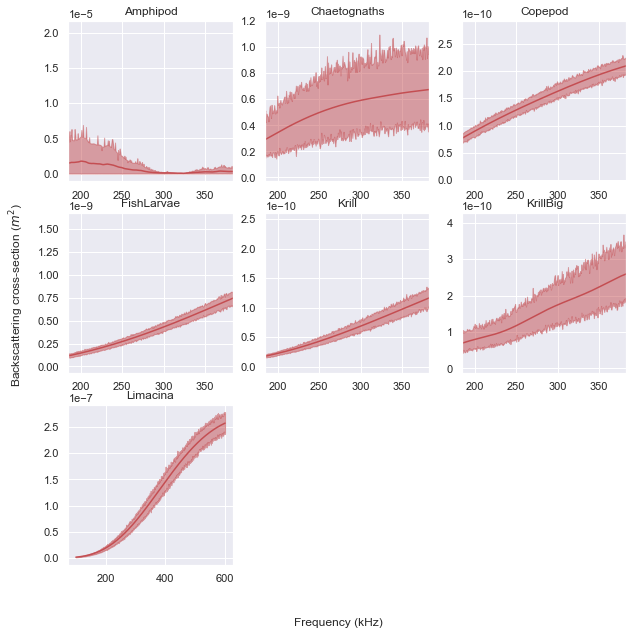

In [8]:
fig=plt.figure(figsize=(10, 10))
plt.ylabel('Backscattering cross-section ($m^2$)')
plt.xlabel('Frequency (kHz)')
for ind in range(len(np.unique(simulations.spec))):
    species = np.unique(simulations.spec)[ind]
    mean, ci_boot = bootstrap_interval(simulations, species)
    freqs = np.unique(simulations.freq)
    
    plt.xlim([185,383])
    plt.subplot(3,3,ind+1)
    plt.plot(freqs, mean, 'r')
    plt.fill_between(freqs, ci_boot[0,:], ci_boot[1,:], alpha=0.5, color='r')
    plt.title(species)
fig.text(0.5, 0.04, 'Frequency (kHz)', ha='center')
fig.text(0.04, 0.5, 'Backscattering cross-section ($m^2$)', va='center', rotation='vertical')

Same as seaborn lineplot calculation, they smooth or have less intervals. But same.

ValueError: num must be 1 <= num <= 3, not 4

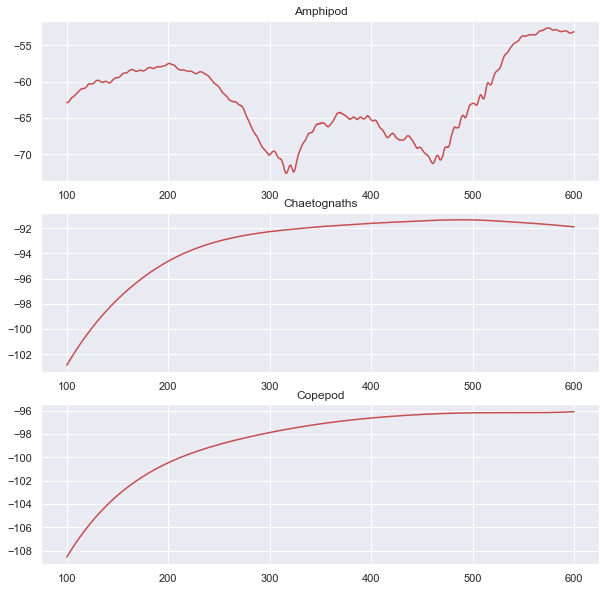

In [11]:
fig=plt.figure(figsize=(10, 10))
plt.ylabel('TS ($dB re m^2$)')
plt.xlabel('Frequency (kHz)')
for ind in range(len(np.unique(simulations.spec))):
    species = np.unique(simulations.spec)[ind]
    mean, ci_boot = bootstrap_interval(simulations, species)
    ci_boot
    freqs = np.unique(simulations.freq)
    
    plt.subplot(3,1,ind+1)
    plt.plot(freqs, 10*np.log10(mean), 'r')
    #plt.fill_between(freqs, 10*np.log10(ci_boot[0,:]), 10*np.log(ci_boot[1,:]), alpha=0.5, color='r')
    plt.title(species)
fig.text(0.5, 0.04, 'Frequency (kHz)', ha='center')
fig.text(0.04, 0.5, 'TS ($dB re m^2$)', va='center', rotation='vertical')

In [ ]:
# Range for 333 or 200
fig=plt.figure(figsize=(15, 10))
plt.ylabel('Backscattering cross-section ($m^2$)')
plt.xlabel('Frequency (kHz)')
for ind in range(len(np.unique(simulations.spec))):
    species = np.unique(simulations.spec)[ind]
    mean, ci_boot = bootstrap_interval(simulations, species)
    freqs = np.unique(simulations.freq)
    
    plt.subplot(4,2,ind+1)
    plt.plot(freqs, mean, 'r')
    plt.fill_between(freqs, ci_boot[0,:], ci_boot[1,:], alpha=0.5, color='r')
    plt.title(species)
    plt.xlim([185,255])
fig.text(0.5, 0.04, 'Frequency (kHz)', ha='center')
fig.text(0.04, 0.5, 'Backscattering cross-section ($m^2$)', va='center', rotation='vertical')

In [ ]:
# Range for 333 or 200
fig=plt.figure(figsize=(10, 20))
plt.ylabel('Backscattering cross-section ($m^2$)')
plt.xlabel('Frequency (kHz)')
for ind in range(len(np.unique(simulations.spec))):
    species = np.unique(simulations.spec)[ind]
    mean, ci_boot = bootstrap_interval(simulations, species)
    freqs = np.unique(simulations.freq)
    
    plt.subplot(4,2,ind+1)
    plt.plot(freqs, mean, 'r')
    plt.fill_between(freqs, ci_boot[0,:], ci_boot[1,:], alpha=0.5, color='r')
    plt.title(species)
    plt.xlim([283,383])
fig.text(0.5, 0.04, 'Frequency (kHz)', ha='center')
fig.text(0.04, 0.5, 'Backscattering cross-section ($m^2$)', va='center', rotation='vertical')

In [ ]:
min(ci_boot)

In [ ]:
max(ci_boot)